# Full Matrix Verification and Analysis

This notebook verifies the full matrix run described in `PROPOSAL.md` and provides a first-pass analysis of indexed vs no-index tradeoffs. The goals are:

- Confirm every expected configuration (indexing x ratio x concurrency) is present.
- Flag duplicates, missing runs, or config mismatches.
- Summarize p95 latency and throughput outcomes in the context of the decision question.


In [1]:
from __future__ import annotations

import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RESULTS_DIR = Path('../results')
EXPECTED_RATIOS = [(90, 10), (50, 50), (10, 90)]
EXPECTED_CONCURRENCY = [1, 4, 8, 16, 32]
EXPECTED_INDEXED = [False, True]

FILENAME_RE = re.compile(r'^(indexed|no_index)_r(\d+)w(\d+)_c(\d+)_(\d{8}T\d+Z)\.json$')


In [2]:
# Discover result files and parse filename metadata.
rows = []
for path in RESULTS_DIR.glob('*.json'):
    match = FILENAME_RE.match(path.name)
    if not match:
        continue
    indexed_label, read_ratio, write_ratio, concurrency, timestamp = match.groups()
    rows.append({
        'path': path,
        'indexed_label': indexed_label,
        'indexed': indexed_label == 'indexed',
        'read_ratio': int(read_ratio),
        'write_ratio': int(write_ratio),
        'concurrency': int(concurrency),
        'timestamp': timestamp,
    })

files_df = pd.DataFrame(rows)
files_df.head()


,path,indexed_label,indexed,read_ratio,write_ratio,concurrency,timestamp
0,../results/indexed_r10w90_c8_20260115T21500659...,indexed,True,10,90,8,20260115T215006594623Z
1,../results/indexed_r50w50_c1_20260115T22085794...,indexed,True,50,50,1,20260115T220857946698Z
2,../results/no_index_r90w10_c4_20260115T2112313...,no_index,False,90,10,4,20260115T211231327282Z
3,../results/indexed_r90w10_c16_20260115T2259186...,indexed,True,90,10,16,20260115T225918604449Z
4,../results/indexed_r10w90_c1_20260115T21373462...,indexed,True,10,90,1,20260115T213734625037Z


In [3]:
# Load JSON contents and validate against filename metadata.
records = []
op_records = []

for row in files_df.itertuples(index=False):
    with open(row.path, 'r') as handle:
        data = json.load(handle)

    config = data.get('config', {})
    summary = data.get('summary', {})

    mismatch = (
        bool(config.get('indexed')) != row.indexed
        or config.get('read_write_ratio', [None, None])[0] != row.read_ratio
        or config.get('read_write_ratio', [None, None])[1] != row.write_ratio
        or config.get('concurrency') != row.concurrency
    )

    records.append({
        'path': row.path,
        'indexed': row.indexed,
        'read_ratio': row.read_ratio,
        'write_ratio': row.write_ratio,
        'concurrency': row.concurrency,
        'timestamp': row.timestamp,
        'dataset_size': config.get('dataset_size'),
        'duration_seconds': data.get('duration_seconds'),
        'total_operations': data.get('total_operations'),
        'operations_per_second': data.get('operations_per_second'),
        'config_mismatch': mismatch,
    })

    for op_name, stats in summary.items():
        op_records.append({
            'path': row.path,
            'indexed': row.indexed,
            'read_ratio': row.read_ratio,
            'write_ratio': row.write_ratio,
            'concurrency': row.concurrency,
            'timestamp': row.timestamp,
            'op': op_name,
            'count': stats.get('count'),
            'success': stats.get('success'),
            'error': stats.get('error'),
            'p50_latency_ms': stats.get('p50_latency_ms'),
            'p95_latency_ms': stats.get('p95_latency_ms'),
            'p99_latency_ms': stats.get('p99_latency_ms'),
        })

results_df = pd.DataFrame(records)
ops_df = pd.DataFrame(op_records)

results_df.head()


,path,indexed,read_ratio,write_ratio,concurrency,timestamp,dataset_size,duration_seconds,total_operations,operations_per_second,config_mismatch
0,../results/indexed_r10w90_c8_20260115T21500659...,True,10,90,8,20260115T215006594623Z,1000000,300.012202,731085,2436.850883,False
1,../results/indexed_r50w50_c1_20260115T22085794...,True,50,50,1,20260115T220857946698Z,1000000,300.001143,1182046,3940.138315,False
2,../results/no_index_r90w10_c4_20260115T2112313...,False,90,10,4,20260115T211231327282Z,1000000,300.132949,7440,24.789014,False
3,../results/indexed_r90w10_c16_20260115T2259186...,True,90,10,16,20260115T225918604449Z,1000000,300.033009,690033,2299.856950,False
4,../results/indexed_r10w90_c1_20260115T21373462...,True,10,90,1,20260115T213734625037Z,1000000,300.001643,558546,1861.809804,False


In [4]:
# Verify full matrix coverage (indexing x ratio x concurrency).
expected = pd.MultiIndex.from_product(
    [EXPECTED_INDEXED, EXPECTED_RATIOS, EXPECTED_CONCURRENCY],
    names=['indexed', 'ratio', 'concurrency'],
).to_frame(index=False)
expected['read_ratio'] = expected['ratio'].apply(lambda x: x[0])
expected['write_ratio'] = expected['ratio'].apply(lambda x: x[1])
expected = expected.drop(columns=['ratio'])

run_counts = (
    results_df.groupby(['indexed', 'read_ratio', 'write_ratio', 'concurrency'])
    .size()
    .reset_index(name='runs')
)

coverage = expected.merge(
    run_counts,
    on=['indexed', 'read_ratio', 'write_ratio', 'concurrency'],
    how='left',
).fillna({'runs': 0})

missing = coverage[coverage['runs'] == 0]
duplicates = coverage[coverage['runs'] > 1]

print('Expected runs:', len(expected))
print('Observed runs:', len(results_df))
print('Missing configs:', len(missing))
print('Duplicate configs:', len(duplicates))
missing


Expected runs: 30
Observed runs: 30
Missing configs: 0
Duplicate configs: 0


,indexed,concurrency,read_ratio,write_ratio,runs


In [5]:
# Show any duplicates for review.
duplicates


,indexed,concurrency,read_ratio,write_ratio,runs


In [6]:
# Show any filename/config mismatches (should be empty).
results_df[results_df['config_mismatch']].sort_values('path')


,path,indexed,read_ratio,write_ratio,concurrency,timestamp,dataset_size,duration_seconds,total_operations,operations_per_second,config_mismatch


In [7]:
# For analysis, select the most recent run per configuration (handles duplicates).
results_df['timestamp_dt'] = pd.to_datetime(results_df['timestamp'], format='%Y%m%dT%H%M%S%fZ')
latest_runs = (
    results_df.sort_values('timestamp_dt')
    .groupby(['indexed', 'read_ratio', 'write_ratio', 'concurrency'], as_index=False)
    .tail(1)
)

latest_ops = ops_df.merge(
    latest_runs[['path']],
    on='path',
    how='inner',
)

latest_runs.head()


,path,indexed,read_ratio,write_ratio,concurrency,timestamp,dataset_size,duration_seconds,total_operations,operations_per_second,config_mismatch,timestamp_dt
25,../results/no_index_r10w90_c1_20260115T2003370...,False,10,90,1,20260115T200337084207Z,1000000,300.003015,74914,249.710824,False,2026-01-15 20:03:37.084207
12,../results/no_index_r10w90_c4_20260115T2009530...,False,10,90,4,20260115T200953032258Z,1000000,300.140368,67503,224.904769,False,2026-01-15 20:09:53.032258
9,../results/no_index_r10w90_c8_20260115T2016091...,False,10,90,8,20260115T201609140520Z,1000000,300.096891,62120,206.999812,False,2026-01-15 20:16:09.140520
21,../results/no_index_r10w90_c16_20260115T202225...,False,10,90,16,20260115T202225217738Z,1000000,300.402605,90188,300.223761,False,2026-01-15 20:22:25.217738
6,../results/no_index_r10w90_c32_20260115T202841...,False,10,90,32,20260115T202841171617Z,1000000,300.650893,98354,327.136897,False,2026-01-15 20:28:41.171617


## Baseline sanity checks

These checks validate that the workload mix and error rates look reasonable before deeper interpretation.


In [8]:
# Error rates per operation type.
error_rates = (
    latest_ops.assign(error_rate=lambda df: df['error'] / df['count'])
    .groupby(['indexed', 'read_ratio', 'write_ratio', 'concurrency', 'op'])
    .agg(error_rate=('error_rate', 'mean'))
    .reset_index()
)
error_rates.sort_values('error_rate', ascending=False).head(10)


,indexed,read_ratio,write_ratio,concurrency,op,error_rate
72,False,90,10,32,range_order,0.395695
71,False,90,10,32,point_lookup,0.329017
70,False,90,10,32,insert,0.306295
73,False,90,10,32,range_scan,0.300510
74,False,90,10,32,update,0.253950
47,False,50,50,32,range_order,0.236676
22,False,10,90,32,range_order,0.123373
46,False,50,50,32,point_lookup,0.109587
45,False,50,50,32,insert,0.058772
48,False,50,50,32,range_scan,0.056954


In [9]:
# Confirm workload mix is near configured ratios (based on operation counts).
read_ops = {'point_lookup', 'range_scan', 'range_order'}
write_ops = {'insert', 'update'}

mix = (
    latest_ops.groupby(['path', 'indexed', 'read_ratio', 'write_ratio', 'concurrency'])
    .apply(lambda df: pd.Series({
        'read_ops': df[df['op'].isin(read_ops)]['count'].sum(),
        'write_ops': df[df['op'].isin(write_ops)]['count'].sum(),
    }))
    .reset_index()
)
mix['observed_read_ratio'] = mix['read_ops'] / (mix['read_ops'] + mix['write_ops']) * 100
mix[['indexed', 'read_ratio', 'write_ratio', 'concurrency', 'observed_read_ratio']].head()


/tmp/ipykernel_35461/3540961538.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({


,indexed,read_ratio,write_ratio,concurrency,observed_read_ratio
0,True,10,90,16,9.997933
1,True,10,90,1,10.072581
2,True,10,90,32,10.009194
3,True,10,90,4,10.004527
4,True,10,90,8,10.028382


## Performance analysis

We focus on p95 latency (primary metric) and throughput (secondary). For summary views, read and write p95 are computed as a **weighted average of per-operation p95s** based on operation counts. This is not a true percentile over all operations, but it is a consistent indicator for comparing configurations.


In [10]:
# Weighted p95 helper.
def weighted_p95(frame: pd.DataFrame) -> float:
    weights = frame['count'].to_numpy(dtype=float)
    values = frame['p95_latency_ms'].to_numpy(dtype=float)
    if weights.sum() == 0:
        return float('nan')
    return float(np.average(values, weights=weights))

read_summary = (
    latest_ops[latest_ops['op'].isin(read_ops)]
    .groupby(['indexed', 'read_ratio', 'write_ratio', 'concurrency'])
    .apply(weighted_p95)
    .reset_index(name='read_p95_ms')
)

write_summary = (
    latest_ops[latest_ops['op'].isin(write_ops)]
    .groupby(['indexed', 'read_ratio', 'write_ratio', 'concurrency'])
    .apply(weighted_p95)
    .reset_index(name='write_p95_ms')
)

perf = latest_runs.merge(read_summary, on=['indexed', 'read_ratio', 'write_ratio', 'concurrency'])
perf = perf.merge(write_summary, on=['indexed', 'read_ratio', 'write_ratio', 'concurrency'])

perf.head()


/tmp/ipykernel_35461/2062418054.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_p95)
/tmp/ipykernel_35461/2062418054.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_p95)


,path,indexed,read_ratio,write_ratio,concurrency,timestamp,dataset_size,duration_seconds,total_operations,operations_per_second,config_mismatch,timestamp_dt,read_p95_ms,write_p95_ms
0,../results/no_index_r10w90_c1_20260115T2003370...,False,10,90,1,20260115T200337084207Z,1000000,300.003015,74914,249.710824,False,2026-01-15 20:03:37.084207,38.853152,1.457976
1,../results/no_index_r10w90_c4_20260115T2009530...,False,10,90,4,20260115T200953032258Z,1000000,300.140368,67503,224.904769,False,2026-01-15 20:09:53.032258,262.641730,2.638148
2,../results/no_index_r10w90_c8_20260115T2016091...,False,10,90,8,20260115T201609140520Z,1000000,300.096891,62120,206.999812,False,2026-01-15 20:16:09.140520,526.550350,2.959132
3,../results/no_index_r10w90_c16_20260115T202225...,False,10,90,16,20260115T202225217738Z,1000000,300.402605,90188,300.223761,False,2026-01-15 20:22:25.217738,600.252046,78.298225
4,../results/no_index_r10w90_c32_20260115T202841...,False,10,90,32,20260115T202841171617Z,1000000,300.650893,98354,327.136897,False,2026-01-15 20:28:41.171617,1320.256116,83.472576


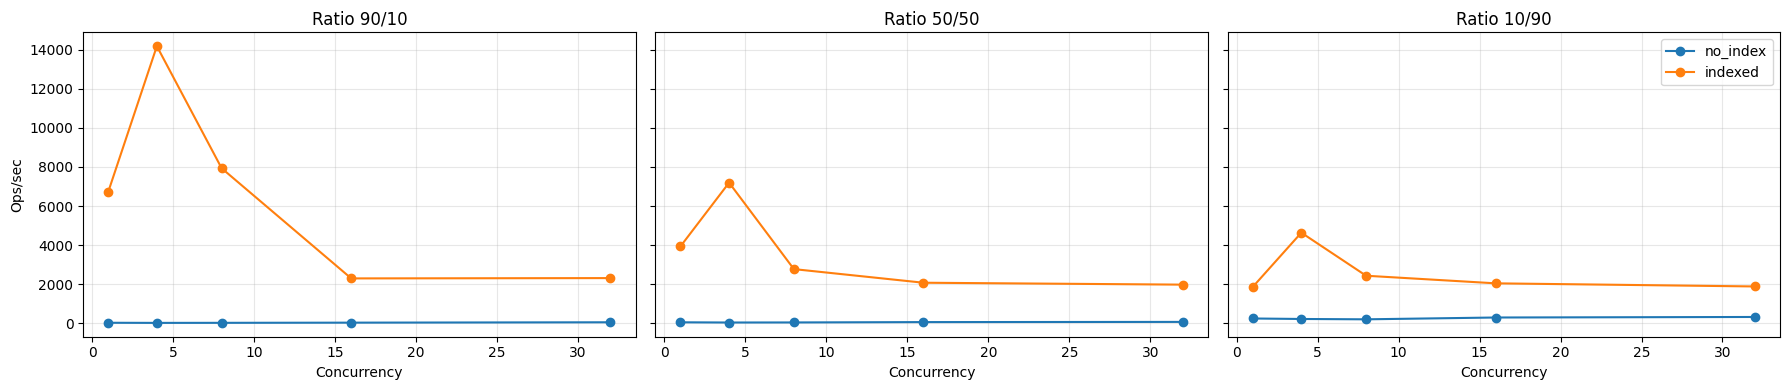

In [11]:
# Throughput vs concurrency, split by ratio.
ratios = EXPECTED_RATIOS
fig, axes = plt.subplots(1, len(ratios), figsize=(18, 4), sharey=True)

for ax, ratio in zip(axes, ratios):
    r, w = ratio
    subset = perf[(perf['read_ratio'] == r) & (perf['write_ratio'] == w)]
    for indexed in [False, True]:
        label = 'indexed' if indexed else 'no_index'
        line = subset[subset['indexed'] == indexed]
        ax.plot(line['concurrency'], line['operations_per_second'], marker='o', label=label)
    ax.set_title(f'Ratio {r}/{w}')
    ax.set_xlabel('Concurrency')
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Ops/sec')
axes[-1].legend()
plt.tight_layout()
plt.show()


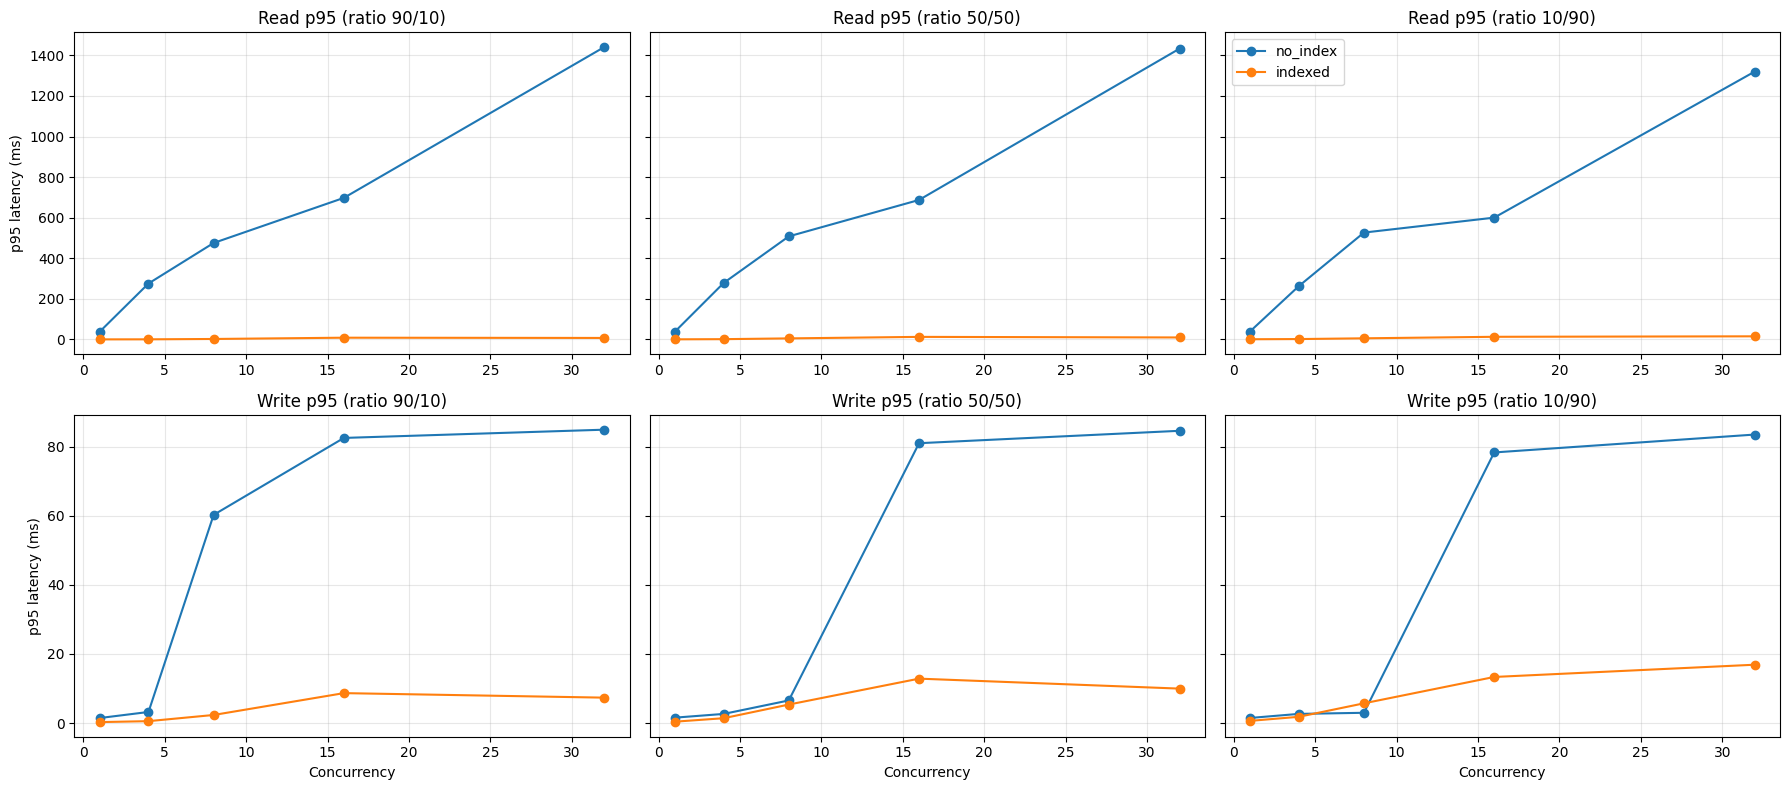

In [12]:
# Read vs write p95 latency by concurrency.
fig, axes = plt.subplots(2, len(ratios), figsize=(18, 8), sharey='row')

for idx, ratio in enumerate(ratios):
    r, w = ratio
    subset = perf[(perf['read_ratio'] == r) & (perf['write_ratio'] == w)]
    for indexed in [False, True]:
        label = 'indexed' if indexed else 'no_index'
        line = subset[subset['indexed'] == indexed]
        axes[0, idx].plot(line['concurrency'], line['read_p95_ms'], marker='o', label=label)
        axes[1, idx].plot(line['concurrency'], line['write_p95_ms'], marker='o', label=label)

    axes[0, idx].set_title(f'Read p95 (ratio {r}/{w})')
    axes[1, idx].set_title(f'Write p95 (ratio {r}/{w})')
    axes[1, idx].set_xlabel('Concurrency')
    axes[0, idx].grid(True, alpha=0.3)
    axes[1, idx].grid(True, alpha=0.3)

axes[0, 0].set_ylabel('p95 latency (ms)')
axes[1, 0].set_ylabel('p95 latency (ms)')
axes[0, -1].legend()
plt.tight_layout()
plt.show()


In [13]:
# Index benefit ratio: indexed / no_index for read and write p95.
indexed_perf = perf[perf['indexed']].set_index(['read_ratio', 'write_ratio', 'concurrency'])
no_index_perf = perf[~perf['indexed']].set_index(['read_ratio', 'write_ratio', 'concurrency'])

benefit = indexed_perf[['read_p95_ms', 'write_p95_ms', 'operations_per_second']].divide(
    no_index_perf[['read_p95_ms', 'write_p95_ms', 'operations_per_second']]
)

benefit = benefit.reset_index()
benefit.head()


,read_ratio,write_ratio,concurrency,read_p95_ms,write_p95_ms,operations_per_second
0,10,90,1,0.019642,0.421907,7.455863
1,10,90,4,0.006538,0.680606,20.624518
2,10,90,8,0.010238,1.924824,11.772237
3,10,90,16,0.021412,0.170191,6.821025
4,10,90,32,0.011527,0.202107,5.772142


In [14]:
# Heatmap-ready view (values < 1.0 mean indexed is better for latency).
benefit_pivot = benefit.pivot_table(
    index='concurrency',
    columns=['read_ratio', 'write_ratio'],
    values='read_p95_ms',
)
benefit_pivot


read_ratio,10,50,90
write_ratio,90,50,10
concurrency,,,
1,0.019642,0.009854,0.003895
4,0.006538,0.004362,0.001372
8,0.010238,0.009870,0.004509
16,0.021412,0.018162,0.012099
32,0.011527,0.006708,0.004998


## Notes to capture in the final report

- Where read p95 improves with indexing, quantify the delta vs write p95 regression.
- Identify any concurrency knee points (sharp latency growth).
- Check if throughput aligns with the read/write latency tradeoff.
- If any error rates are non-zero, cross-check logs and the timeout settings.
